#  Dataset: House Prices - Advanced Regression Techniques

---

##  Objetivo del dataset
- **Meta principal**: **Predecir el precio de venta de una casa (`SalePrice`)** en la ciudad de Ames (Iowa, EE.UU.).
- **Cómo se logra**: mediante modelos de **regresión múltiple** u otros algoritmos de Machine Learning, usando como insumo las características de la casa (tamaño, materiales, condiciones, ubicación, etc.).

---

##  Pasos para llegar al objetivo
1. **Comprensión del problema**  
   - Variable dependiente: `SalePrice`.
   - Variables independientes: características estructurales, de ubicación, materiales y extras.

2. **Exploración de los datos (EDA)**  
   - Revisar registros, valores nulos, tipos de datos.
   - Generar estadísticas descriptivas y distribuciones.

3. **Limpieza de datos**  
   - Imputar o eliminar valores faltantes (`NA`).
   - Tratar valores atípicos.
   - Agrupar categorías poco frecuentes.

4. **Codificación de variables categóricas**  
   - Usar *One Hot Encoding* o *Label Encoding*.

5. **Escalamiento / Normalización**  
   - Aplicar sobre variables numéricas cuando el modelo lo requiera.

6. **Selección de variables relevantes**  
   - Usar correlaciones, ANOVA o técnicas de *feature selection*.

7. **Construcción del modelo**  
   - Empezar con **Regresión Lineal Múltiple**.
  

8. **Evaluación del modelo**  
- **RMSE (Root Mean Squared Error):** mide el error promedio, penaliza más los errores grandes.  
- **MAE (Mean Absolute Error):** error promedio absoluto entre lo real y lo predicho.  
- **R² (Coeficiente de determinación):** indica qué tan bien el modelo explica la variabilidad (0 a 1).  
- **Validación cruzada:** divide los datos en partes para entrenar y probar el modelo de forma más robusta.  


9. **Interpretación de resultados**  
   - Identificar qué variables influyen más en el precio de venta.

---

##  Resumen de variables principales
El dataset contiene **79 variables**. Algunos ejemplos clave:

- **Lote**
  - `MSSubClass`: tipo de vivienda (1 piso, 2 pisos, dúplex, PUD).  
  - `MSZoning`: zonificación (residencial, comercial, agrícola).  
  - `LotFrontage`: longitud de fachada.  
  - `LotArea`: área del terreno.  
  - `LotShape`: forma del lote (regular, irregular).  
  - `LandContour`: topografía (plano, pendiente, depresión).  
  - `Neighborhood`: barrio donde se ubica la casa.  

- **Construcción**
  - `BldgType`: tipo de construcción (unifamiliar, dúplex, townhouse).  
  - `HouseStyle`: estilo (1 piso, 2 pisos, split-level).  
  - `OverallQual`: calidad general (1 = muy mala, 10 = excelente).  
  - `OverallCond`: estado general de la vivienda.  
  - `YearBuilt`: año de construcción.  
  - `YearRemodAdd`: año de remodelación.  
  - `RoofStyle` / `RoofMatl`: tipo y material del techo.  
  - `Exterior1st` / `Exterior2nd`: material exterior.  

- **Sótano**
  - `BsmtQual`, `BsmtCond`: calidad y estado del sótano.  
  - `BsmtExposure`: exposición (ventanas, walkout).  
  - `TotalBsmtSF`: área total del sótano.  

- **Habitabilidad**
  - `GrLivArea`: área habitable sobre el nivel del suelo.  
  - `FullBath`, `HalfBath`: baños.  
  - `Bedroom`, `Kitchen`: habitaciones y cocinas.  
  - `TotRmsAbvGrd`: total de cuartos.  

- **Extras**
  - `Fireplaces`, `FireplaceQu`: chimeneas.  
  - `GarageType`, `GarageCars`, `GarageArea`: características del garaje.  
  - `WoodDeckSF`, `OpenPorchSF`, `PoolArea`, `Fence`: áreas exteriores y amenidades.  

- **Venta**
  - `MoSold`, `YrSold`: mes y año de venta.  
  - `SaleType`: tipo de venta (convencional, cash, VA loan).  
  - `SaleCondition`: condiciones de la venta (normal, familiar, parcial, etc.).  

- **Target**
  - `SalePrice`: precio de venta de la vivienda (variable a predecir).

---

##  En resumen
El dataset busca **explicar y predecir el precio de las casas** usando información estructural, de ubicación, calidad de materiales, extras y condiciones de venta.


In [ ]:
#1
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

#2
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#3
cols_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu', 'Id']
train_df_clean = train_df.drop(columns=cols_to_drop)
test_df_clean = test_df.drop(columns=[c for c in cols_to_drop if c in test_df.columns])


for col in train_df_clean.columns:
    if train_df_clean[col].dtype == 'object':  # categóricas
        modo = train_df_clean[col].mode()[0]
        train_df_clean[col] = train_df_clean[col].fillna(modo)
        if col in test_df_clean.columns:
            test_df_clean[col] = test_df_clean[col].fillna(modo)
    else:  # numéricas
        mediana = train_df_clean[col].median()
        train_df_clean[col] = train_df_clean[col].fillna(mediana)
        if col in test_df_clean.columns:
            test_df_clean[col] = test_df_clean[col].fillna(mediana)


#4
train_df_encoded = pd.get_dummies(train_df_clean)
test_df_encoded = pd.get_dummies(test_df_clean)


missing_cols = set(train_df_encoded.columns) - set(test_df_encoded.columns)
for col in missing_cols:
    test_df_encoded[col] = 0

if 'SalePrice' in test_df_encoded.columns:
    test_df_encoded = test_df_encoded.drop(columns=['SalePrice'])


feature_cols = train_df_encoded.drop(columns=['SalePrice']).columns
test_df_encoded = test_df_encoded[feature_cols]


#5
X = train_df_encoded.drop(columns=['SalePrice'])
y = train_df_encoded['SalePrice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#7
model = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(n_estimators=200, random_state=42)
)

#8
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_scores = np.sqrt(-cv_scores)  

print("🔁 Resultados de Validación Cruzada (5 folds):")
print(f"RMSE por fold: {np.round(cv_rmse_scores, 2)}")
print(f"RMSE promedio: {cv_rmse_scores.mean():.2f}  ± {cv_rmse_scores.std():.2f}")


model.fit(X_train, y_train)


y_pred = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("\n📊 Evaluación en el set de validación:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


#9
gbr = model.named_steps['gradientboostingregressor']
feature_importances = gbr.feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTop 10 features por importance (GradientBoosting):")
print(feat_imp_df.head(10))

print("\n⏳ Calculando Permutation Importance (puede tardar)...")
perm_result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({
    'feature': X.columns,
    'perm_importance_mean': perm_result.importances_mean,
    'perm_importance_std': perm_result.importances_std
}).sort_values('perm_importance_mean', ascending=False).reset_index(drop=True)

print("\nTop 10 features por Permutation Importance:")
print(perm_df.head(10))


#10
test_predictions = model.predict(test_df_encoded)
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': test_predictions})
submission.to_csv('submission.csv', index=False)
print("\n📁 Predicciones guardadas en 'submission.csv'.")


🔁 Resultados de Validación Cruzada (5 folds):
RMSE por fold: [21930.86 30654.62 27525.33 22226.13 27857.29]
RMSE promedio: 26038.85  ± 3412.74

📊 Evaluación en el set de validación:
RMSE: 26107.80
MAE : 15952.09
R²  : 0.9111

Top 10 features por importance (GradientBoosting):
            feature  importance
0       OverallQual    0.506946
1         GrLivArea    0.141115
2       TotalBsmtSF    0.043737
3        GarageCars    0.043473
4        BsmtFinSF1    0.031157
5          2ndFlrSF    0.029146
6          1stFlrSF    0.027520
7           LotArea    0.017797
8  GarageFinish_Unf    0.016539
9         YearBuilt    0.015194

⏳ Calculando Permutation Importance (puede tardar)...

Top 10 features por Permutation Importance:
       feature  perm_importance_mean  perm_importance_std
0  OverallQual              0.217528             0.016766
1    GrLivArea              0.156071             0.013781
2     2ndFlrSF              0.028423             0.001126
3  TotalBsmtSF              0.023161   

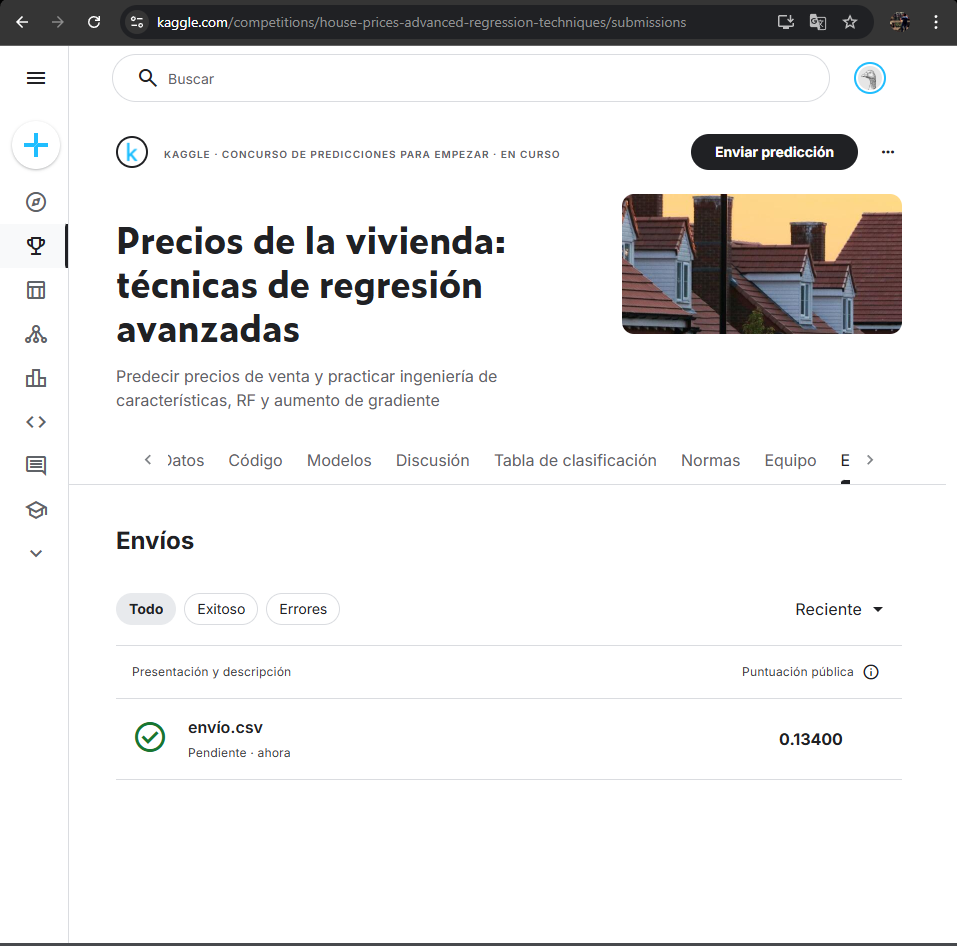